# IPI ASSESSMENT <br>
###  by James Lee, April 3rd 2020
### jihunlee.jhl@gmail.com

# Introduction

## Import Libraries

In [225]:
import re
import gc
import sys
import math
import tqdm
import eli5
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from joblib import dump, load
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, cohen_kappa_score, balanced_accuracy_score


## Read Data

In [253]:
df = pd.read_excel('C:/Users/jihun/Downloads/billsData-4.xlsx')

## Inspect Data

In [228]:
df.columns

Index(['newId', 'Fiscal Note', 'New Act', 'Pensions', 'Finance', 'Revenue',
       'Reached Floor', 'democraticCosponsor', 'republicanCosponsors',
       'primaryRace', 'bipartisan', 'primarySex_Female', 'primarySex_Male',
       'primarySex_nan', 'Chamber_HB', 'Chamber_SB', 'Election_Status_0',
       'Election_Status_1', 'Election_Status_2', 'primaryParty_D',
       'primaryParty_R', 'primaryIsLeader_No', 'primaryIsLeader_Yes',
       'primaryAge_missing', 'primaryAge_twenties', 'primaryAge_thirties',
       'primaryAge_fourties', 'primaryAge_fifties', 'primaryAge_sixties',
       'primaryAge_seventies'],
      dtype='object')

In [229]:
df.shape

(2000, 30)

This dataset a relatively small dataset of 2,000 rows and 16 columns, so we can afford to run many models.

### newId is the unique key?

In [231]:
df[df['newId'].duplicated() == True]

,newId,Fiscal Note,New Act,Pensions,Finance,Revenue,Reached Floor,democraticCosponsor,republicanCosponsors,primaryRace,...,primaryParty_R,primaryIsLeader_No,primaryIsLeader_Yes,primaryAge_missing,primaryAge_twenties,primaryAge_thirties,primaryAge_fourties,primaryAge_fifties,primaryAge_sixties,primaryAge_seventies


Yes, it is.

## Response Variable

TARGET variable in binary in nature. So this is a binary classification problem.

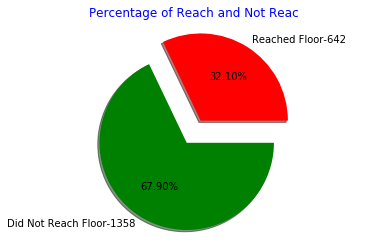

In [232]:
pie_labels=['Reached Floor-'+str(df['Reached Floor'][df['Reached Floor']==1].count()),'Did Not Reach Floor-'+str(df['Reached Floor'][df['Reached Floor']==0].count())]
pie_share=[df['Reached Floor'][df['Reached Floor']==1].count()/df['Reached Floor'].count(),
           df['Reached Floor'][df['Reached Floor']==0].count()/df['Reached Floor'].count()]
figureObject, axesObject = plt.subplots()
pie_colors=('red','green')
pie_explode=(.3,.0)
axesObject.pie(pie_share,labels=pie_labels,explode=pie_explode,autopct='%.2f%%',colors=pie_colors,startangle=0,shadow=True)
axesObject.axis('equal')
plt.title('Percentage of Reach and Not Reac',color='blue')
plt.show()

The percentage of Bills That Reached the Floor is 67.90%, which is slightly imbalanced but not problematic. We can later use imbalance-robust metrics such as kappa score and balanced accuracy for selecting the models. There is no need for oversampling or other techniques to correct data imbalance.

## Predictor Variables

At large, the predictor variables can be classified into four categories: 1) topics: fiscal, revenue, pension, finance 2) measure of support: dem/republican cosponsors, 3) info about primary author: sex, age, race, leader status, party 4) others: chamber, new act, intro election status.

# Data Preprocessing

## What are the variable types?

The categorical variables are 1) chamber 2) fiscal note 3) New Act 4) Pensions 5) Finance 6) Revenue 7) primaryParty 8) primaryRace 9) primarySex 10) primaryIsLeader 11) Intro Election Status.

The numeric variables are 1) democraticSponsor 2) republicanCosponsor 3) primaryAge.

In [235]:
df.dtypes

newId                    object
Chamber                  object
Fiscal Note               int64
Intro Election Status     int64
New Act                   int64
Pensions                  int64
Finance                   int64
Revenue                   int64
Reached Floor             int64
democraticCosponsor       int64
republicanCosponsors      int64
primaryParty             object
primaryRace               int64
primaryAge                int64
primarySex               object
primaryIsLeader          object
dtype: object

### Label encode the Variables for correlation analysis

(When modeling, variable will be one hot encoded)

In [ ]:
df1 = df
df2 = df

In [239]:
num_col = ['newId','democraticCosponsor','republicanCosponsors','primaryAge']
cat_col = [item for item in df1.columns if item not in num_col]
for col in cat_col:
    df1[col],_ = df1[col].factorize()

In [240]:
df1.dtypes

newId                    object
Chamber                   int64
Fiscal Note               int64
Intro Election Status     int64
New Act                   int64
Pensions                  int64
Finance                   int64
Revenue                   int64
Reached Floor             int64
democraticCosponsor       int64
republicanCosponsors      int64
primaryParty              int64
primaryRace               int64
primaryAge                int64
primarySex                int64
primaryIsLeader           int64
dtype: object

# Univariate Analysis

## Distributions

Looking at the means of some of the binary variables, we can tell that they are very skewed. For instance, the mean of Fiscal Note is 0.02, which means only 2% of data had a fiscal note attached with it.

In [241]:
df1.describe()

,Chamber,Fiscal Note,Intro Election Status,New Act,Pensions,Finance,Revenue,Reached Floor,democraticCosponsor,republicanCosponsors,primaryParty,primaryRace,primaryAge,primarySex,primaryIsLeader
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.347500,0.02100,0.632500,0.070500,0.04800,0.106000,0.108500,0.321000,1.977000,0.918000,0.638500,0.258000,48.529000,0.647000,0.621500
std,0.476295,0.14342,0.807942,0.256052,0.21382,0.307915,0.311089,0.466978,5.153033,3.477114,0.480555,0.437643,17.782133,0.514318,0.485134
min,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,51.000000,1.000000,1.000000
75%,1.000000,0.00000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000,1.000000,1.000000
max,1.000000,1.00000,2.000000,1.000000,1.00000,1.000000,1.000000,1.000000,61.000000,53.000000,1.000000,1.000000,80.000000,1.000000,1.000000


I will make plots of univariate distribution for each variable to detect any pattern or anomaly.

In [247]:
def make_plots(Vs):
    col = 4
    row = len(Vs)//4+1
    plt.figure(figsize=(20,row*5))
    idx = df1[~df1[Vs[0]].isna()].index
    for i,v in enumerate(Vs):
        plt.subplot(row,col,i+1)
        n = df1[v].nunique()
        x = np.sum(df1.loc[idx,v]!=df1.loc[idx,v].astype(int))
        y = np.round(100*np.sum(df1[v].isna())/len(df1),2)
        t = 'int'
        if x!=0: t = 'float'
        plt.title(v+' has '+str(n)+' '+t+' and '+str(y)+'% nan')
        plt.yticks([])
        h = plt.hist(df1.loc[idx,v],bins=100)
        if len(h[0])>1: plt.ylim((0,np.sort(h[0])[-2]))
    plt.show()

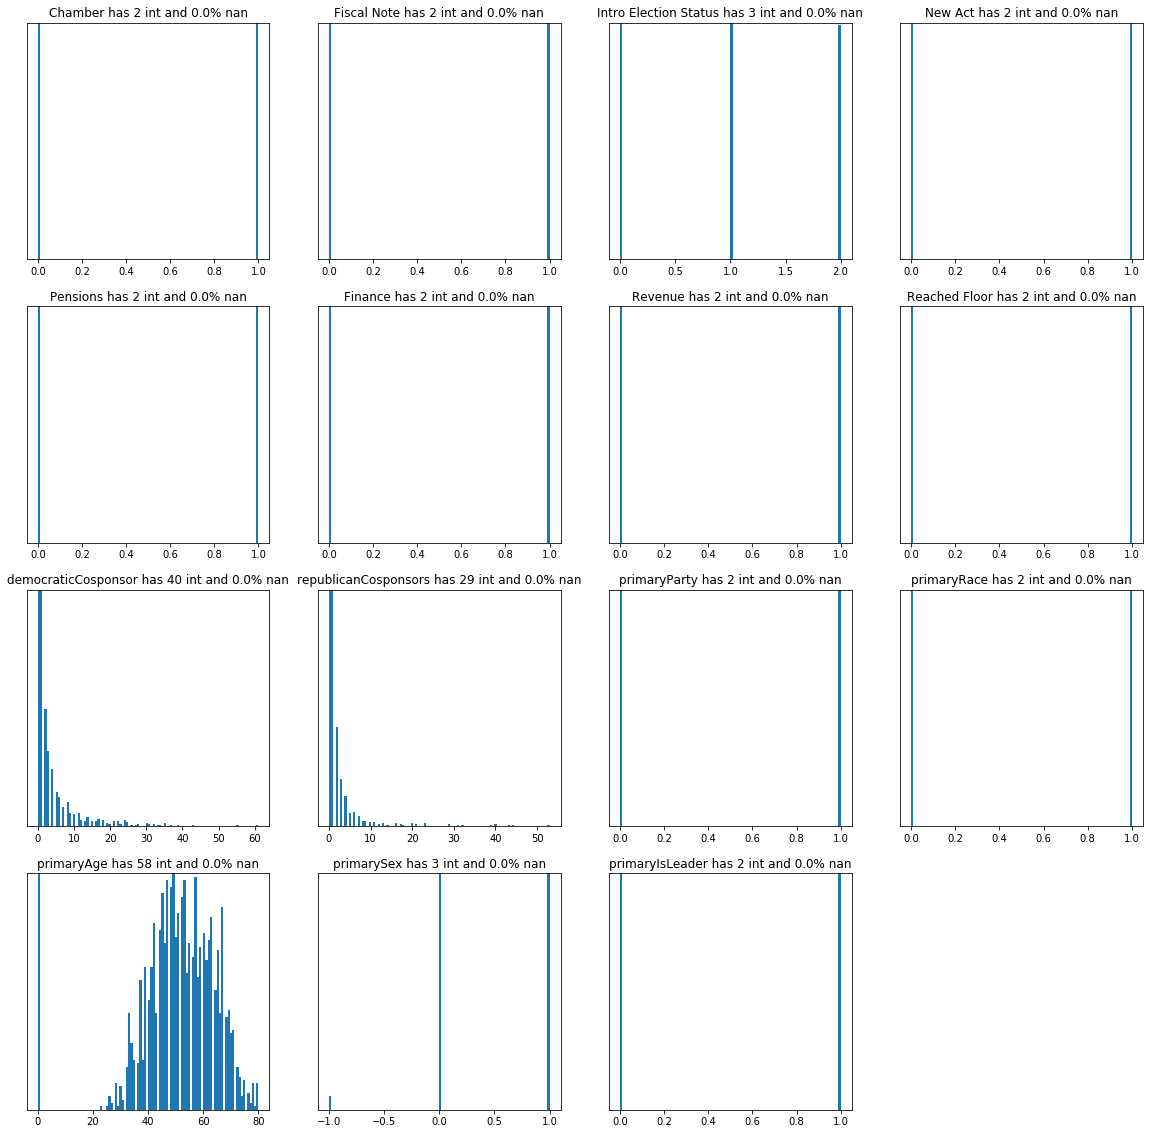

In [249]:
make_plots(df1.columns[1:])

Note: primarySex's -1 is actually NaN.

This plot below is an example of severe data imbalance among some predictor variables.

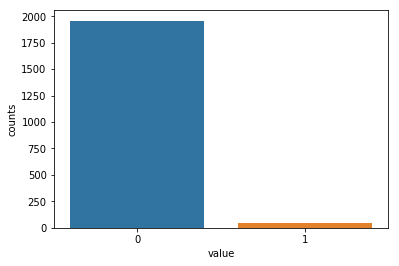

In [252]:
df3 = df1['Fiscal Note'].value_counts().reset_index()
df3.columns = ['value', 'counts']
sns.barplot(x='value',y='counts',data=df3)

As one can see 'Fiscal Note' variable is very imbalanced, and this may tell us if the variable is not informative enough because it does not have enough variance.

## Outlier

We can notice 'primaryAge' variable has many 0 values, and this is an impossible value for age. So I assume this is actually missing value.

## Normality
We can observe primaryAge has roughly bell-shaped, unimodal curve, if we exclude 0's. We also see that democratic cosponsors and republican cosponsors are very right skewed. Later we will make these features smoothed out using square root transform.

## Missing Values

In [255]:
nans_df = df2.isna()
nans_groups={}
for col in df2.columns:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

for k,v in nans_groups.items():
    print('####### NAN count =',k)
    print(v)

####### NAN count = 0
['newId', 'Chamber', 'Fiscal Note', 'Intro Election Status', 'New Act', 'Pensions', 'Finance', 'Revenue', 'Reached Floor', 'democraticCosponsor', 'republicanCosponsors', 'primaryParty', 'primaryRace', 'primaryAge', 'primaryIsLeader']
####### NAN count = 36
['primarySex']


'primarySex' variable has 36 rows of missing entries, and 'primaryAge' has about 150 0's. 

In order to deal with missing values, my logic is the following: <br>
1. Check if data are missing completely at random. If this is the case, we can remove the rows without creating bias at the cost of losing only 2% of rows (if we only remove gender). However, deleting all 150 rows of age is going too far.
2. There is no way to confidently check if data are missing at random or not at random, since information to determine this is missing. There are many ways to go about the missing value problem then. Since dataset is relatively small (2,000 rows) I do not want to delete missing rows, and will impute them.

#### Checking whether values are missing completely at random

There are a few statistical methods to check this. One informal way is to check whether the distribution of other variables in the missing rows are a representative sample of the entire data.

In [258]:
# subset of data with gender missing
df2[df2.isna().any(axis=1)]

,newId,Chamber,Fiscal Note,Intro Election Status,New Act,Pensions,Finance,Revenue,Reached Floor,democraticCosponsor,republicanCosponsors,primaryParty,primaryRace,primaryAge,primarySex,primaryIsLeader
4,HB637-96,HB,0,0,0,0,0,0,0,1,0,R,0,0,NaN,No
20,SB751-100,SB,0,0,0,0,0,0,1,0,0,D,0,40,NaN,Yes
46,HB1193-97,HB,0,0,0,0,0,0,1,7,0,D,1,55,NaN,Yes
51,HB3523-101,HB,0,0,0,0,0,1,0,0,0,R,0,45,NaN,No
66,HB2967-100,HB,0,0,0,0,0,0,0,0,0,D,0,43,NaN,Yes
69,SB3235-101,SB,0,2,0,0,0,0,0,1,0,D,1,46,NaN,Yes
73,HB5832-97,HB,0,2,0,0,0,0,0,0,0,R,0,63,NaN,No
94,HB3919-101,HB,0,0,0,1,0,0,0,0,1,R,1,45,NaN,No
128,HB4344-101,HB,0,2,0,0,0,0,0,0,1,R,1,63,NaN,No
183,SB3449-101,SB,0,2,1,0,0,0,0,1,0,D,0,34,NaN,No


Almost the majority of missing values has age = 0, but this is not representative of the data. We can reject the null hypothesis that the gender variable is missing completely at random.

### Just Delete the Columns?
Later in the model, it turns out these two variables are not important in the final model, so we can also consider dropping these variables entirely.


### Why are gender and age missing?
Age and gender information should not be hard to find out about the primary sponsor since they are public figures with high visibility. So, it is hard to conjecture why these values can be missing in systematic pattern and I suspect hey could really be missing at random due to data entry error. Regardless, as I said earlier, deleting missing rows does not seem to be a strategic decision, and I will impute the missing values.

# Bivariate Relationships

## Correlation Among Variables - Checking for Multicollinearity

In [265]:
def make_corr(Vs,Vtitle=''):
    cols = Vs
    plt.figure(figsize=(17,17))
    sns.heatmap(df1[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    if Vtitle!='': plt.title(Vtitle,fontsize=14)
    else: plt.title(Vs[0]+' - '+Vs[-1],fontsize=14)
    plt.show()

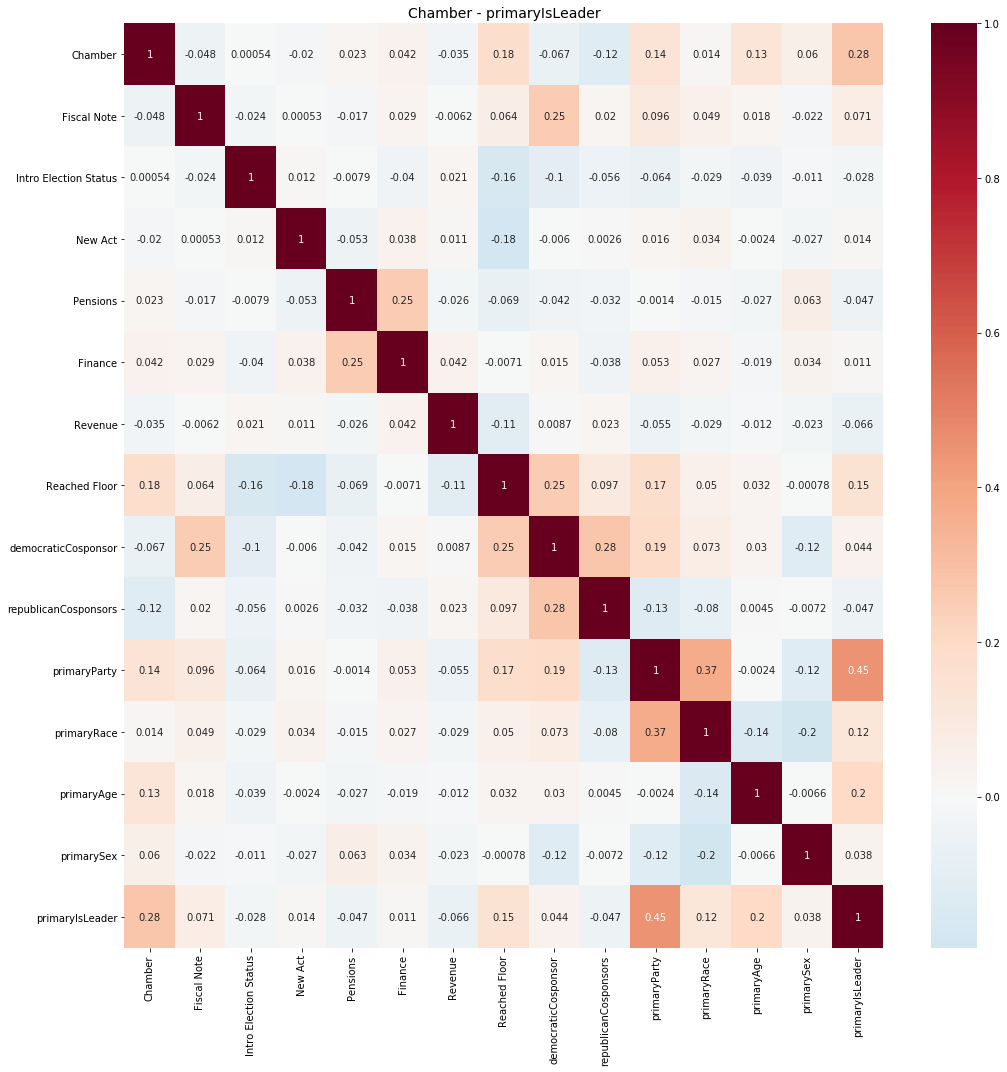

In [266]:
make_corr(df1.columns[1:])

No evidence of strong correlation exists among all the variables (>0.75) to combine, reduce-dimensionality, or remove any redundant variables.

One thing I notice is that the number of cosponsors has the highest correlations with Reached Floor. On the other hand, binary variables like Fiscal Note, Pension, and Finance have barely any correlations, which may arise from the fact that they are near zero-variance variables and have little information in them.

# Feature Engineering

### Id columns - the last digits
One thing I noticed is that the last digits of id's have only values from 97 to 101, so I created this variable but later dropped it in the final model.

In [ ]:
def last_number(s):
    result = re.findall('\d+(?!.*-)', s)
    result = ''.join(result)
    return(result)

In [ ]:
df['id_digits'] = df['newId'].apply(last_number)

### Interaction Variables
bipartisan support: I hypothesize that a bill with bipartisan support will more likely reach a floor.
#### 1 = when there are more than 1 cosponsor ffrom each party, 0 = else

In [14]:
def bipartisan(dem,rep):
    if dem > 0 and rep >0:
        return(1)
    else:
        return(0)

In [15]:
df['bipartisan'] = np.vectorize(bipartisan)(df['democraticCosponsor'],df['republicanCosponsors'])

### One Hot Encoding Categorical Variables

For modeling purpose, we one hot encode all the categorical variables.

In [16]:
# All the missing observations are grouped in the newly created label ‘Missing’. It does not assume anything on the missingness of the values. 
df = pd.concat([df, pd.get_dummies(df['primarySex'], prefix='primarySex',dummy_na=True)], axis=1) 
df = pd.concat([df, pd.get_dummies(df['Intro Election Status'], prefix='Election_Status')], axis=1)
df.drop(['primarySex'],axis=1, inplace=True)
df.drop(['Intro Election Status'],axis=1, inplace=True)

In [275]:
df.columns

Index(['newId', 'Fiscal Note', 'New Act', 'Pensions', 'Finance', 'Revenue',
       'Reached Floor', 'democraticCosponsor', 'republicanCosponsors',
       'primaryRace', 'bipartisan', 'primarySex_Female', 'primarySex_Male',
       'primarySex_nan', 'Chamber_HB', 'Chamber_SB', 'Election_Status_0',
       'Election_Status_1', 'Election_Status_2', 'primaryParty_D',
       'primaryParty_R', 'primaryIsLeader_No', 'primaryIsLeader_Yes',
       'primaryAge_missing', 'primaryAge_twenties', 'primaryAge_thirties',
       'primaryAge_fourties', 'primaryAge_fifties', 'primaryAge_sixties',
       'primaryAge_seventies'],
      dtype='object')

In [ ]:
# Label encode the following variables
cols = ['Chamber','primaryParty','primaryIsLeader']
for col in cols:
    df[col],_ = df1[col].factorize()

### Avoid Overidentification

Delete kth column to avoid linear dependency of design matrix.

In [ ]:
df.drop(['primarySex_nan'], axis=1) 
df.drop(['Election_Status_2'], axis=1)

### Power Transform Democratic and Republican Cosponsors

In order to smooth out the skewness of Democratic and Republican cosponsors, I use the square root transform. The variables are still skewed but less pronouncedly so.

In [17]:
df['democraticCosponsor'] = df.democraticCosponsor**(1/2)
df['republicanCosponsors'] = df.republicanCosponsors**(1/2)

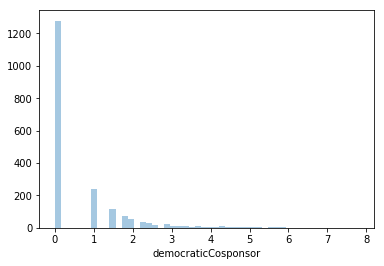

In [20]:
sns.distplot(df['democraticCosponsor'], kde=False)

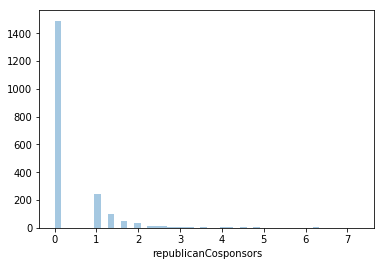

In [21]:
sns.distplot(df['republicanCosponsors'], kde=False)

### Missing Value Imputation

#### Method of Choice: Bin the primaryAge variable

This helps us capture non-linear effects, but discretizing continuous variable can significantly reduce information within the variable, so I create many bins (20s, 30s, 40s, 50s, 60s, 70s).

In [22]:
df['primaryAge'] = pd.cut(df.primaryAge,bins=[-1,20,30,40,50,60,70,100],labels=['missing','twenties','thirties','fourties','fifties','sixties','seventies'])

In [34]:
df = pd.concat([df, pd.get_dummies(df['primaryAge'], prefix='primaryAge')], axis=1)
df.drop(['primaryAge'],axis=1, inplace=True)

Create separate category of NaN for primarySex variable. This was already done in One Hot Encoding.

In [ ]:
# I also explored KNN imputation and other imputation methods like mean, median for primaryAge
from fancyimpute import KNN 
df_filled_knn = KNN(k=3).complete(df)

# Model

### Pipeline:<br>
1) data split (75%/25%)<br>
2) feature selection (with 5-fold cross valiation)<br>
3) grid search (with 5-fold cross valiation)

## Models
1. Bagging <br>
    a. Random Forest <br>
    b. Extreme Random Forest <br>
2. Boosting <br>
    a. AdaBoost<br>
    b. Gradient Boost<br>
    c. Extreme Gradient Boost<br>
3. Logistic Regression<br>
4. Discriminants<br>
    a. Linear<br>
    b. Quadratic<br>
    c. Nearest Centroid<br>
5. Support Vector Classifier<br>
    a. Linear Kernel<br>
    b. Polynomial Kernel<br>
    c. Radial Basis Function Kernel<br>
6. Neural Net Classifier<br>
7. Gaussian Naive Bayes<br>
8. K Nearest Neighbors<br>
9. Gaussian Process

###  Split Data

In [38]:
X, y = df.drop(columns=['Reached Floor', 'newId']), df['Reached Floor']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

### Feature Selection: Either Chi Squared Filtering or  Recursive Feature Elimination 
### Hyperparameter Tuning: Grid Search
### Overfitting curbed by Train-Test Split (External Validation) and Each Model's Internal Regularization. To get more stable estimate of generalizability of each model, I use 5-fold cross validation.

### Pre-Model Feature Selection: Chi-squared on Categorical Variables

Chi-square is one of the ways of feature selection for categorical features.<br>
Chi-square statistics examines the independence of two categorical vectors.<br>
We will calculate Chi-square score for all the features and try to visualize it.<br>
Chi-square score is calculated for features with respect to target. Chi-squared tests are for categorical variables only but since we know from correlation matrix above that the only numeric variables (democraticCosponsor and republicanCosponsor) are highly correlated with Reached Floor, it is redundant to conduct ROC-AUC tests on them. 

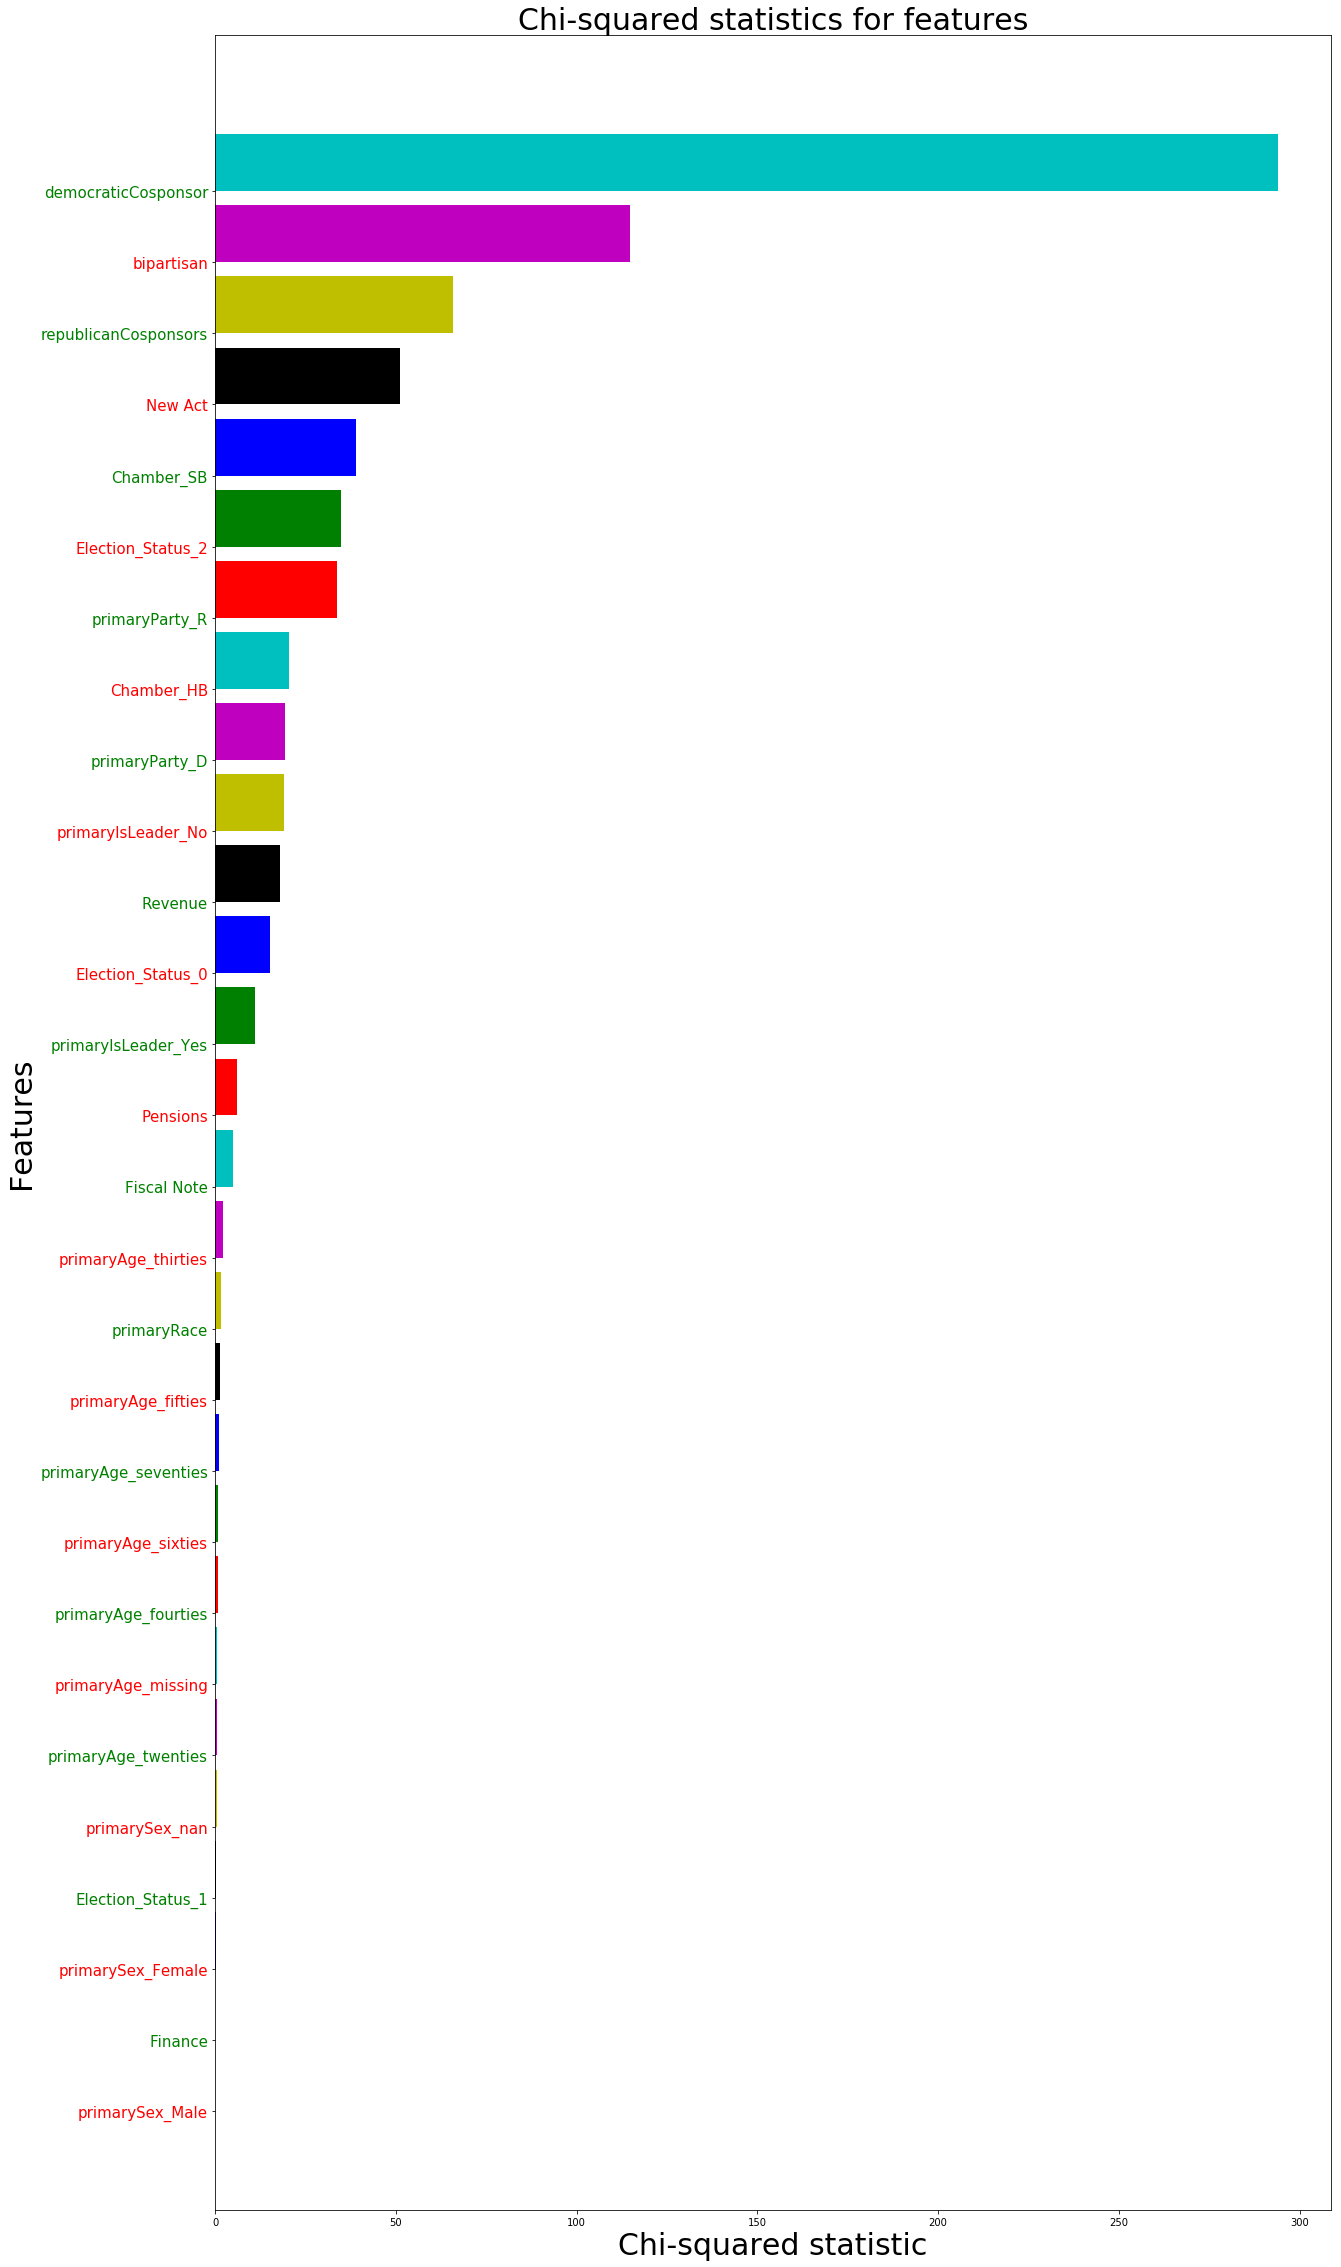

In [147]:
chi2_selector=SelectKBest(chi2,k=15)
feature_kbest=chi2_selector.fit_transform(X_train,y_train)
df_chi=pd.DataFrame(chi2_selector.scores_,columns=['chi_score'])
df_chi['columns']=X_train.columns
df_chi_s=df_chi.sort_values(by='chi_score')

fig,ax=plt.subplots(figsize=(20,40))
plt.title("Chi-squared statistics for features",fontsize=30)
plt.ylabel("Features",fontsize=30)
plt.xlabel("Chi-squared statistic",fontsize=30)
plt.barh(range(len(df_chi_s['chi_score'])),df_chi_s['chi_score'],align='edge',color='rgbkymc')
plt.yticks(range(len(df_chi_s['chi_score'])),df_chi_s['columns'],color='g',fontsize=15)
for i in range(0,28,2):
    ax.get_yticklabels()[i].set_color("red")
plt.show()

#### Columns Selected from Filtering

In [196]:
list(X_train.columns[chi2_selector.get_support(indices=True)])

['Fiscal Note',
 'New Act',
 'Pensions',
 'Revenue',
 'democraticCosponsor',
 'republicanCosponsors',
 'bipartisan',
 'Chamber_HB',
 'Chamber_SB',
 'Election_Status_0',
 'Election_Status_2',
 'primaryParty_D',
 'primaryParty_R',
 'primaryIsLeader_No',
 'primaryIsLeader_Yes']

# Model Evaluation 

This function will print out all the classification metrics.

In [45]:
def evaluation_result(predicted, reference):
    print("Accuracy is: " + str(accuracy_score(reference, predicted)))
    print("F1 score is: " + str(f1_score(reference, predicted)))
    print("Precision is: " + str(precision_score(reference, predicted)))
    print("Recall is: " + str(recall_score(reference, predicted)))
    print("Kappa score is: " + str(cohen_kappa_score(reference, predicted)))
    print("AUC is: " + str(roc_auc_score(reference, predicted)))
    print("Balanced accuracy is: " + str(balanced_accuracy_score(reference, predicted)))
    print(confusion_matrix(y_predict, y_test))


Now I will fit models on the training data, and output performance measures.

#### 1a. Random Forest

In [104]:
clf_featr_sele_1a = RandomForestClassifier(n_jobs=-1,
                                        n_estimators=300, 
                                        random_state=42,
                                        oob_score = True,
                                        class_weight="balanced") 
rfecv_1a = RFECV(estimator=clf_featr_sele_1a, 
              step=1, 
              cv=5, 
              scoring = 'roc_auc')
clf_1a = RandomForestClassifier(random_state=42) 
CV_clf_1a = GridSearchCV(estimator=clf_1a, 
                      param_grid={'n_estimators': [300,500, 700],
                                  'max_features': ['auto'],
                                  'criterion' :['gini', 'entropy'],
                                 'max_depth':np.arange(2,11)},
                      cv= 5, 
                      scoring = 'roc_auc')
pipeline_1a  = Pipeline([('feature_sele',rfecv_1a),
                      ('clf_cv',CV_clf_1a)])

pipeline_1a.fit(X_train, y_train)
y_predict_1a = pipeline_1a.predict(X_test)

In [105]:
dump(pipeline_1a, 'C:/Users/jihun/Desktop/random_forest.joblib') 

['C:/Users/jihun/Desktop/random_forest.joblib']

In [109]:
evaluation_result(y_predict_1a, y_test)

Accuracy is: 0.756
F1 score is: 0.5547445255474452
Precision is: 0.6440677966101694
Recall is: 0.48717948717948717
Kappa score is: 0.3911203385770182
AUC is: 0.6825432319618366
Balanced accuracy is: 0.6825432319618366
[[298  76]
 [ 46  80]]


### 1b. Extreme Random Forest

In [112]:
clf_featr_sele_1b = ExtraTreesClassifier(n_jobs=-1,
                                        n_estimators=300, 
                                        random_state=42,
                                        oob_score = True,
                                         bootstrap=True,
                                        class_weight="balanced") 
rfecv_1b = RFECV(estimator=clf_featr_sele_1b, 
              step=1, 
              cv=5, 
              scoring = 'roc_auc')
clf_1b = ExtraTreesClassifier(random_state=42,
                              oob_score = True,
                              bootstrap=True) 
CV_clf_1b = GridSearchCV(estimator=clf_1b, 
                      param_grid={'n_estimators': [300,500, 700],
                                  'max_features': ['auto'],
                                  'criterion' :['gini', 'entropy'],
                                 'max_depth':np.arange(2,11)},
                      cv= 5, 
                      scoring = 'roc_auc')
pipeline_1b  = Pipeline([('feature_sele',rfecv_1b),
                      ('clf_cv',CV_clf_1b)])

pipeline_1b.fit(X_train, y_train)
y_predict_1b = pipeline_1b.predict(X_test)

In [113]:
dump(pipeline_1b, 'C:/Users/jihun/Desktop/extreme_random_forest.joblib') 

['C:/Users/jihun/Desktop/extreme_random_forest.joblib']

In [114]:
evaluation_result(y_predict_1b, y_test)

Accuracy is: 0.752
F1 score is: 0.5303030303030304
Precision is: 0.6481481481481481
Recall is: 0.44871794871794873
Kappa score is: 0.36930338541666663
AUC is: 0.6691264162194395
Balanced accuracy is: 0.6691264162194395
[[298  76]
 [ 46  80]]


### 2a. AdaBoost Classifier

In [116]:
clf_featr_sele_2a = AdaBoostClassifier(n_estimators=300, 
                                        random_state=42) 
rfecv_2a = RFECV(estimator=clf_featr_sele_2a, 
              step=1, 
              cv=5, 
              scoring = 'roc_auc')
clf_2a = AdaBoostClassifier(random_state=42) 
CV_clf_2a = GridSearchCV(estimator=clf_2a, 
                      param_grid={'n_estimators': [300,500, 700],
                                  'learning_rate':[0.001,0.005,0.01,0.05,0.1,1],
                                 'algorithm':['SAMME','SAMME.R']},
                      cv= 5, 
                      scoring = 'roc_auc')
pipeline_2a  = Pipeline([('feature_sele',rfecv_2a),
                      ('clf_cv',CV_clf_2a)])

pipeline_2a.fit(X_train, y_train)
y_predict_2a = pipeline_2a.predict(X_test)

NameError: name 'pipeline_' is not defined

In [118]:
dump(pipeline_2a, 'C:/Users/jihun/Desktop/adaboost.joblib') 

['C:/Users/jihun/Desktop/adaboost.joblib']

In [119]:
evaluation_result(y_predict_2a, y_test)

Accuracy is: 0.77
F1 score is: 0.5147679324894515
Precision is: 0.7530864197530864
Recall is: 0.391025641025641
Kappa score is: 0.3832325052559318
AUC is: 0.66644305307096
Balanced accuracy is: 0.6664430530709601
[[298  76]
 [ 46  80]]


### 2b. Gradient Boosting Classifier

In [121]:
clf_featr_sele_2b = GradientBoostingClassifier(n_estimators=300, 
                                        random_state=42) 
rfecv_2b = RFECV(estimator=clf_featr_sele_2b, 
              step=1, 
              cv=5, 
              scoring = 'roc_auc')
clf_2b = GradientBoostingClassifier(random_state=42) 
CV_clf_2b = GridSearchCV(estimator=clf_2b, 
                      param_grid={'n_estimators': [300,500, 700],
                                  'learning_rate':[0.001,0.005,0.01,0.05,0.1,1],
                                  'loss':['deviance','exponential'],
                                  'subsample':[0.8,0.9,1.0],
                                  'max_depth': [2,3,5,7],
                                  'max_features':['auto'],
                                     "min_samples_leaf": np.linspace(0.1, 0.5, 5)},
                      cv= 5, 
                      scoring = 'roc_auc')
pipeline_2b  = Pipeline([('feature_sele',rfecv_2b),
                      ('clf_cv',CV_clf_2b)])

pipeline_2b.fit(X_train, y_train)
y_predict_2b = pipeline_2b.predict(X_test)

In [122]:
dump(pipeline_2b, 'C:/Users/jihun/Desktop/gradientboost.joblib') 

['C:/Users/jihun/Desktop/gradientboost.joblib']

In [123]:
evaluation_result(y_predict_2b, y_test)

Accuracy is: 0.766
F1 score is: 0.5411764705882354
Precision is: 0.696969696969697
Recall is: 0.4423076923076923
Kappa score is: 0.39448515712333865
AUC is: 0.6775491949910554
Balanced accuracy is: 0.6775491949910555
[[298  76]
 [ 46  80]]


### 2c. Extreme Gradient Boosting

In [161]:
xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
    metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
alg.set_params(n_estimators=cvresult.shape[0])

#Fit the algorithm on the data
alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')

#Predict training set:
dtrain_predictions = alg.predict(dtrain[predictors])
dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [171]:
alg = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=5,
    metrics='auc', early_stopping_rounds=50
                 )
alg.set_params(n_estimators=cvresult.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=34, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=None, subsample=0.8, verbosity=1)

In [173]:
alg.fit(X_train, y_train,eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=34, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=None, subsample=0.8, verbosity=1)

In [174]:
y_predict_2d = alg.predict(X_test)

In [175]:
evaluation_result(y_predict_2d, y_test)

Accuracy is: 0.754
F1 score is: 0.5714285714285715
Precision is: 0.6259541984732825
Recall is: 0.5256410256410257
Kappa score is: 0.4007483337880501
AUC is: 0.6915995825879546
Balanced accuracy is: 0.6915995825879546
[[298  76]
 [ 46  80]]


### 3.  Logistic Regression

In [ ]:
clf_featr_sele_3 = LogisticRegression(random_state=42)
rfecv_3 = RFECV(estimator=clf_featr_sele_3,
                step=1,
                cv=5,
                scoring='roc_auc')

clf_3 = LogisticRegression(random_state=42)
CV_clf_3 = GridSearchCV(estimator=clf_3,
                        param_grid={'penalty': ['l1','l2'],
                                   'C':np.linspace(0.1,1,10)},
                        cv=5,
                        scoring='roc_auc')
pipeline_3 = Pipeline([('feature_sele',rfecv_3),
                       ('clf_cv',CV_clf_3)])
pipeline_3.fit(X_train,y_train)
y_predict_3 = pipeline_3.predict(X_test)

In [142]:
evaluation_result(y_predict_3, y_test)

Accuracy is: 0.758
F1 score is: 0.5925925925925926
Precision is: 0.624113475177305
Recall is: 0.5641025641025641
Kappa score is: 0.42109694951582655
AUC is: 0.7050163983303518
Balanced accuracy is: 0.7050163983303518
[[298  76]
 [ 46  80]]


### 4a. Linear Discriminants

In [209]:
clf_4a = LinearDiscriminantAnalysis()
CV_clf_4a = GridSearchCV(estimator=clf_4a,
                        param_grid={'solver': ['lsqr','eigen'],  
                                  'shrinkage': ['auto']
                                   },
                        cv=5,
                        scoring='roc_auc')
pipeline_4a = Pipeline([('chi2', chi2_selector),
                       ('clf_cv',CV_clf_4a)])
pipeline_4a.fit(X_train,y_train)
y_predict_4a = pipeline_4a.predict(X_test)
evaluation_result(y_predict_4a, y_test)

Accuracy is: 0.766
F1 score is: 0.5865724381625441
Precision is: 0.6535433070866141
Recall is: 0.532051282051282
Kappa score is: 0.42577250775452513
AUC is: 0.7020721526535479
Balanced accuracy is: 0.702072152653548
[[298  76]
 [ 46  80]]


### 4b. Quadratic Discriminants

In [ ]:
clf_4b = QuadraticDiscriminantAnalysis()
CV_clf_4b = GridSearchCV(estimator=clf_4b,
                        param_grid={'reg_param':np.linspace(0,1,11)},
                        cv=5,
                        scoring='roc_auc')
pipeline_4b = Pipeline([('chi2', chi2_selector),
                       ('clf_cv',CV_clf_4b)])
pipeline_4b.fit(X_train,y_train)
y_predict_4b = pipeline_4b.predict(X_test)

In [152]:
evaluation_result(y_predict_4b, y_test)

Accuracy is: 0.748
F1 score is: 0.5987261146496815
Precision is: 0.5949367088607594
Recall is: 0.6025641025641025
Kappa score is: 0.41506350739062614
AUC is: 0.7082587954680978
Balanced accuracy is: 0.7082587954680978
[[298  76]
 [ 46  80]]


### 4c. Nearest Centroid

In [156]:
clf_4c = NearestCentroid()
CV_clf_4c = GridSearchCV(estimator=clf_4c,
                        param_grid={'metric':['euclidean','manhattan'],
                                    'shrink_threshold':[0.2,0.4,0.6,0.8,1,None]},
                        cv=5)
CV_clf_4c.fit(X_train,y_train)
y_predict_4c = CV_clf_4c.predict(X_test)

In [157]:
evaluation_result(y_predict_4c, y_test)

Accuracy is: 0.744
F1 score is: 0.5844155844155844
Precision is: 0.5921052631578947
Recall is: 0.5769230769230769
Kappa score is: 0.39948956613121145
AUC is: 0.698345259391771
Balanced accuracy is: 0.698345259391771
[[298  76]
 [ 46  80]]


# Interpretation

## Top Model: Linear discriminant analysis

LDA has Kappa score of 0.43, AUC of 0.7, and Balanced Accuracy of 0.7. Since the response variable has a slightly imbalanced distribution, I want to select model based on metrics that are robust to imbalance issues instead of accracy score which can be inflated by data imbalance. On all three metrics, LDA performs the best.

### 1. Best Hyperparameters

In [181]:
pipeline_4a.steps[1][1].best_params_

{'shrinkage': 'auto', 'solver': 'lsqr'}

'lsqr' is least squares solution. 'auto' is automatic shrinkage using Ledoit-Wolf Lemma.

### 2. Variable Scores

Although we applied Chi-squared filtering by the top 15 features, using all the features still output the better model performance.

This table below lists variable by its importance in descending manner.

In [211]:
result = pd.DataFrame({'variables': list(X_train.columns),
          'scores': pipeline_4a.steps[0][1].scores_,
          'p_values': pipeline_4a.steps[0][1].pvalues_})
print(result.sort_values(by=['scores'], ascending=False))

               variables      scores      p_values
5    democraticCosponsor  294.014992  6.633554e-66
8             bipartisan  114.773385  8.822479e-27
6   republicanCosponsors   65.816803  4.948455e-16
1                New Act   51.241588  8.166996e-13
13            Chamber_SB   39.044201  4.143179e-10
16     Election_Status_2   34.886133  3.495617e-09
18        primaryParty_R   33.865137  5.906772e-09
12            Chamber_HB   20.534946  5.855245e-06
17        primaryParty_D   19.326178  1.101853e-05
19    primaryIsLeader_No   19.062140  1.265302e-05
4                Revenue   17.936642  2.283816e-05
14     Election_Status_0   15.243599  9.449648e-05
20   primaryIsLeader_Yes   11.004327  9.089942e-04
2               Pensions    6.111685  1.342910e-02
0            Fiscal Note    5.091387  2.404495e-02
23   primaryAge_thirties    2.122193  1.451785e-01
7            primaryRace    1.689982  1.936034e-01
25    primaryAge_fifties    1.371754  2.415107e-01
27  primaryAge_seventies    1.1

## Analysis of Results

The analysis shows that clout of support behind a bill is the most important predictor of whether a bill will reach a floor vote. Specifically, if a bill has a greater number of cosponsors - and additional influence for bipartisan support - it is more likely to reach a floor vote, which is not surprising. <br>

Interestingly, the weight of Democratic cosponsor is much greater than the Republican counterpart by almost 5 times the magnitude. This makes sense considering the Democrats are in control of both House and Senate in the state of Illinois (assuming this data is from Illinois state legislature), and a chamber majority has greater muscle in making a bill of its ilk to a floor. It implies a Democratic state legislator has more opportunity in having his or her bill passed since it can reach a floor to be debated. <br>

In addition, none of the demographic variables such as age, sex, and race play important role. In contrast, it is interesting that Presidential election year has some influence on the bill's fate as well. 


## How to improve the model?

#### Data collection

Collect more data - say topics of bill other than economic and financial. <br>

However, I feel there is limit to how much new information we can collect such that they are measurable and quantifiable - especially if we assume some bills get decided by behind-the-door talks and negotiations. We know bills that don't have enough support for sure are dead on arrival and  will never reach the floor in the first place. Prior to submitting a bill, legislators gauge support for bills sub rosa, and this is not something that can be measured.

#### Missing data imputation methods

Try other methods to deal with missing values and better elucidate information for models. For instance, age and gender can be imputed simultaneously using MICE interpolation algorithm.

#### Denser grid search

Train my models on more hyperparameter and gain marginal improvements in performance.

#### Different feature engineering

Aggregate near zero variance variables like finance and fiscal note into one variable, since they can be considered to have similar information.